<a href="https://colab.research.google.com/github/missabiss/kaggle_comp_melting_temp/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Competition - Predicting Melting Temperature

KGAT_c5eabcb947a12782c10de181da5245eb token

To use this token, set the KAGGLE_API_TOKEN environment variable:
export KAGGLE_API_TOKEN=KGAT_c5eabcb947a12782c10de181da5245eb

After setting KAGGLE_API_TOKEN, you can use the client as follows:
kaggle competitions list
new key
export KAGGLE_API_TOKEN=KGAT_e7ee6d61bb646ec532b41abbbb113e3b

## Imports

In [3]:
# Setup for Kaggle
import os
os.environ['KAGGLE_USERNAME'] = "ashleybissell"
os.environ['KAGGLE_API_TOKEN'] = "KGAT_e7ee6d61bb646ec532b41abbbb113e3b"
# %env KAGGLE_KEY=KGAT_c5eabcb947a12782c10de181da5245eb
!pip install kaggle --upgrade --quiet
print("Kaggle setup complete.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 17.8 MB/s eta 0:00:00
Kaggle setup complete.


In [4]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 71.8 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from google.colab import files
import shutil
from rdkit import Chem
from rdkit.Chem import AllChem, Draw


## Load Data

In [6]:
!kaggle competitions download -c melting-point
!unzip melting-point.zip
print("Data loaded.")

100% 94.4k/94.4k [00:00<00:00, 743kB/s]
100% 94.4k/94.4k [00:00<00:00, 742kB/s]
Archive:  melting-point.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
Data loaded.


In [7]:
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

train_df.head()

,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Chatgpt version

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from tqdm import tqdm

def make_3d_conformer(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    mol = Chem.AddHs(mol)
    try:
        params = AllChem.ETKDGv3()  # most stable/accurate embedding
        params.randomSeed = 42  # reproducibility
        AllChem.EmbedMolecule(mol, params)
        AllChem.MMFFOptimizeMolecule(mol)
        return mol
    except:
        return None

# Parallel processing of SMILES
train_df['mol3D'] = Parallel(n_jobs=-1)(
    delayed(make_3d_conformer)(s) for s in tqdm(train_df['SMILES']))

100%|██████████| 2662/2662 [00:07<00:00, 369.77it/s]


In [7]:
notna_train = int(train_df['mol3D'].notna().sum())
total_train = len(train_df)
print(f"{notna_train}/{total_train} successful conversions.")

2659/2662 successful conversions.


In [8]:
test_df['mol3D'] = Parallel(n_jobs=-1)(
    delayed(make_3d_conformer)(s) for s in tqdm(test_df['SMILES'])
)
test_df['mol3D'].notna().sum()
notna_test = int(test_df['mol3D'].notna().sum())
total_test = len(test_df)
print(f"{notna_test}/{total_test} successful conversions.")

100%|██████████| 666/666 [00:01<00:00, 536.19it/s]


666/666 successful conversions.


In [9]:
!pip install rdkit-pypi joblib torch torchvision tqdm --quiet

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import AllChem

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------
# CONFIG
# ------------------
GRID_SIZE = 32        # voxel resolution (can increase to 48 or 64 later)
ENCODING_MODE = "per_element"   # "grouped" or "per_element"
TARGET_COL = "Tm"  # melting temp

ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
Using device: cuda


In [10]:
def get_unique_atomic_numbers(smiles_list):
    nums = set()
    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol is None:
            continue
        mol = Chem.AddHs(mol)
        for atom in mol.GetAtoms():
            nums.add(atom.GetAtomicNum())
    return sorted(nums)

all_smiles = pd.concat([train_df["SMILES"], test_df["SMILES"]], ignore_index=True)
unique_Z = get_unique_atomic_numbers(all_smiles)
print("Unique atomic numbers in dataset:", unique_Z)

Unique atomic numbers in dataset: [1, 6, 7, 8, 9, 14, 15, 16, 17, 35, 53]


In [11]:
def build_atom_map(unique_Z, mode="grouped"):
    if mode == "grouped":
        # You can tweak these groupings later
        grouped_map = {}
        channel = 0

        # Helper to assign groups if present
        def assign(z_list):
            nonlocal channel
            for z in z_list:
                if z in unique_Z:
                    grouped_map[z] = channel
            channel += 1

        # Groups (adjust as needed)
        assign([6])                 # C
        assign([8])                 # O
        assign([7])                 # N
        assign([9])                 # F
        assign([17, 35, 53])        # Cl, Br, I
        assign([16, 15])            # S, P
        assign([14])                # Si
        assign([1])                 # H

        # Any remaining elements -> one extra "other" channel
        remaining = [z for z in unique_Z if z not in grouped_map]
        if remaining:
            for z in remaining:
                grouped_map[z] = channel
            channel += 1

        num_channels = channel
        print("Grouped encoding: channels =", num_channels)
        print("Atom map:", grouped_map)
        return grouped_map, num_channels

    elif mode == "per_element":
        atom_map = {z: i for i, z in enumerate(unique_Z)}
        num_channels = len(unique_Z)
        print("Per-element encoding: channels =", num_channels)
        print("Atom map:", atom_map)
        return atom_map, num_channels

    else:
        raise ValueError("ENCODING_MODE must be 'grouped' or 'per_element'")

ATOM_MAP, VOXEL_CHANNELS = build_atom_map(unique_Z, mode=ENCODING_MODE)


Per-element encoding: channels = 11
Atom map: {1: 0, 6: 1, 7: 2, 8: 3, 9: 4, 14: 5, 15: 6, 16: 7, 17: 8, 35: 9, 53: 10}


In [12]:
def make_3d_conformer(smiles, random_seed=42):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    mol = Chem.AddHs(mol)
    try:
        params = AllChem.ETKDGv3()
        params.randomSeed = random_seed
        AllChem.EmbedMolecule(mol, params)
        AllChem.MMFFOptimizeMolecule(mol)
        return mol
    except Exception:
        return None

# Parallel over train
train_df["mol3D"] = Parallel(n_jobs=-1)(
    delayed(make_3d_conformer)(s) for s in tqdm(train_df["SMILES"], desc="Train 3D")
)

# Parallel over test
test_df["mol3D"] = Parallel(n_jobs=-1)(
    delayed(make_3d_conformer)(s) for s in tqdm(test_df["SMILES"], desc="Test 3D")
)

print("Train 3D success rate:", train_df["mol3D"].notna().mean())
print("Test 3D success rate:", test_df["mol3D"].notna().mean())

Test 3D: 100%|██████████| 666/666 [00:01<00:00, 505.61it/s]


Train 3D success rate: 0.9988730277986476
Test 3D success rate: 1.0


In [13]:
def mol_to_voxel(mol, atom_map, num_channels, grid_size=GRID_SIZE):
    if mol is None:
        return None

    conf = mol.GetConformer()
    num_atoms = mol.GetNumAtoms()
    coords = np.array([conf.GetAtomPosition(i) for i in range(num_atoms)], dtype=float)

    # Center coordinates
    coords = coords - coords.mean(axis=0)
    max_range = np.abs(coords).max()
    if max_range < 1e-6:
        return None  # degenerate geometry

    coords = coords / (max_range + 1e-6)

    # Map from [-1,1] -> [0, grid_size)
    coords = (coords + 1.0) * (grid_size / 2.0)
    coords = coords.astype(int)

    vox = np.zeros((num_channels, grid_size, grid_size, grid_size), dtype=np.float32)

    for i, atom in enumerate(mol.GetAtoms()):
        x, y, z = coords[i]
        if 0 <= x < grid_size and 0 <= y < grid_size and 0 <= z < grid_size:
            znum = atom.GetAtomicNum()
            ch = atom_map.get(znum, None)
            if ch is not None:
                vox[ch, x, y, z] = 1.0

    return vox

# Voxelize train
train_df["vox"] = Parallel(n_jobs=-1)(
    delayed(mol_to_voxel)(mol, ATOM_MAP, VOXEL_CHANNELS)
    for mol in tqdm(train_df["mol3D"], desc="Train voxels")
)

# Voxelize test
test_df["vox"] = Parallel(n_jobs=-1)(
    delayed(mol_to_voxel)(mol, ATOM_MAP, VOXEL_CHANNELS)
    for mol in tqdm(test_df["mol3D"], desc="Test voxels")
)

print("Train voxel success rate:", train_df["vox"].notna().mean())
print("Test voxel success rate:", test_df["vox"].notna().mean())

Test voxels: 100%|██████████| 666/666 [00:01<00:00, 408.74it/s]


Train voxel success rate: 0.9988730277986476
Test voxel success rate: 1.0


In [14]:
train_df = train_df[train_df["vox"].notna()].reset_index(drop=True)
test_df  = test_df[test_df["vox"].notna()].reset_index(drop=True)

print("Final train size:", len(train_df))
print("Final test size:", len(test_df))

Final train size: 2659
Final test size: 666


In [15]:
train_df.to_pickle(f"train_voxels_{ENCODING_MODE}.pkl")
test_df.to_pickle(f"test_voxels_{ENCODING_MODE}.pkl")

In [20]:
# Get mean and std of target
y_mean = train_df[TARGET_COL].mean()
y_std  = train_df[TARGET_COL].std()

print("Mean:", y_mean, "Std:", y_std)

Mean: 278.0095374200827 Std: 84.30936235458189


In [23]:
class MoleculeVoxelDataset(Dataset):
    def __init__(self, df, target_col=None, mean=None, std=None):
        self.X = np.stack(df['vox'].values)
        self.target_col = target_col
        self.mean = mean
        self.std = std

        if target_col is not None:
            self.y = ((df[target_col].values - mean) / std).astype(np.float32)
        else:
            self.y = None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx])
        if self.y is not None:
            y = torch.tensor(self.y[idx])
            return x, y
        return x

# Split train into train/val
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(
    np.arange(len(train_df)), test_size=0.2, random_state=42
)
train_subset = train_df.iloc[train_idx].reset_index(drop=True)
val_subset   = train_df.iloc[val_idx].reset_index(drop=True)

train_dataset = MoleculeVoxelDataset(train_subset, TARGET_COL, y_mean, y_std)
val_dataset   = MoleculeVoxelDataset(val_subset,   TARGET_COL, y_mean, y_std)
test_dataset  = MoleculeVoxelDataset(test_df)  # no labels

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, num_workers=2)

Epoch 01 | Train MSE: 1.79 | Train MAE: 0.90 | Val MSE: 0.80 | Val MAE: 0.68
Epoch 02 | Train MSE: 0.81 | Train MAE: 0.69 | Val MSE: 0.65 | Val MAE: 0.58
Epoch 03 | Train MSE: 0.70 | Train MAE: 0.63 | Val MSE: 0.62 | Val MAE: 0.55
Epoch 04 | Train MSE: 0.62 | Train MAE: 0.59 | Val MSE: 0.69 | Val MAE: 0.58
Epoch 05 | Train MSE: 0.57 | Train MAE: 0.56 | Val MSE: 0.81 | Val MAE: 0.65
Epoch 06 | Train MSE: 0.56 | Train MAE: 0.55 | Val MSE: 0.49 | Val MAE: 0.52
Epoch 07 | Train MSE: 0.52 | Train MAE: 0.53 | Val MSE: 0.48 | Val MAE: 0.50
Epoch 08 | Train MSE: 0.50 | Train MAE: 0.53 | Val MSE: 0.48 | Val MAE: 0.52
Epoch 09 | Train MSE: 0.49 | Train MAE: 0.52 | Val MSE: 0.47 | Val MAE: 0.48
Epoch 10 | Train MSE: 0.48 | Train MAE: 0.52 | Val MSE: 0.44 | Val MAE: 0.47
Epoch 11 | Train MSE: 0.45 | Train MAE: 0.51 | Val MSE: 0.56 | Val MAE: 0.54
Epoch 12 | Train MSE: 0.42 | Train MAE: 0.49 | Val MSE: 0.55 | Val MAE: 0.53
Epoch 13 | Train MSE: 0.39 | Train MAE: 0.47 | Val MSE: 0.55 | Val MAE: 0.56

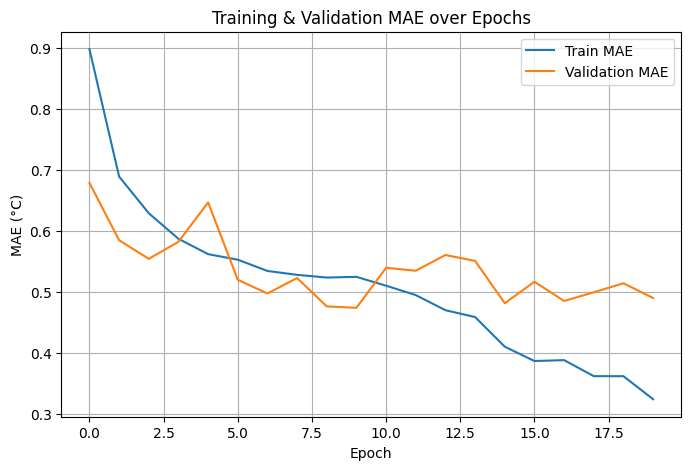

In [25]:
class Mol3DCNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_channels, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),         # -> 16^3
            nn.Conv3d(32, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),         # -> 8^3
            nn.Conv3d(64, 128, 3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d(2),         # -> 4^3
            nn.Flatten(),
            nn.Linear(128 * 4 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)        # regression: melting point
        )

    def forward(self, x):
        return self.net(x)

for var in ['model', 'optimizer', 'scheduler']:
    if var in globals():
        del globals()[var]

torch.cuda.empty_cache()
torch.cuda.empty_cache()
model = Mol3DCNN(in_channels=VOXEL_CHANNELS).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      # minimize validation loss
    factor=0.5,      # reduce LR by 50%
    patience=3,      # wait 3 epochs before reducing
)

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_mae = 0
    count = 0

    for batch in loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        if train:
            optimizer.zero_grad()

        preds = model(x).squeeze(-1)
        loss = criterion(preds, y)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Track metrics
        total_loss += loss.item() * x.size(0)
        total_mae  += torch.abs(preds - y).sum().item()
        count += x.size(0)

    mse = total_loss / count
    mae = total_mae / count
    return mse, mae

EPOCHS = 10
train_losses = []
val_losses = []
train_maes = []
val_maes = []
for epoch in range(1, EPOCHS + 1):
    train_mse, train_mae = run_epoch(train_loader, train=True)
    val_mse,   val_mae   = run_epoch(val_loader,   train=False)

    train_losses.append(train_mse)
    val_losses.append(val_mse)
    train_maes.append(train_mae)
    val_maes.append(val_mae)

    scheduler.step(val_mse)  # if using ReduceLROnPlateau

    print(f"Epoch {epoch:02d} | "
          f"Train MSE: {train_mse:.2f} | Train MAE: {train_mae:.2f} | "
          f"Val MSE: {val_mse:.2f} | Val MAE: {val_mae:.2f}")

plt.figure(figsize=(8,5))
plt.plot(train_maes, label="Train MAE")
plt.plot(val_maes, label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE (°C)")
plt.title("Training & Validation MAE over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
all_preds = []

with torch.no_grad():
    for x in DataLoader(test_dataset, batch_size=8, shuffle=False):
        x = x.to(device)
        preds = model(x).squeeze(-1).cpu().numpy()
        all_preds.extend(preds)

test_df["prediction"] = all_preds
test_df[["prediction"]].head()

In [ ]:
test_df.head()

In [26]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# ======= CONFIG =======
TARGET_COL = "Tm"   # <-- CHANGE THIS IF DIFFERENT
BATCH_SIZE = 8
EPOCHS = 20
K = 5
DEVICE = device
OUTPUT_DIM = 1

# ====== NORMALIZATION PARAMS (from TRAIN ONLY) ======
y_mean = train_df[TARGET_COL].mean()
y_std  = train_df[TARGET_COL].std()

print("Training target mean:", y_mean, "std:", y_std)

# ===== DATASET CLASS WITH NORMALIZED TARGET =====
class VoxelDataset(Dataset):
    def __init__(self, df, target_col=None):
        self.X = np.stack(df['vox'].values).astype(np.float32)
        self.has_target = target_col is not None

        if self.has_target:
            self.y = ((df[target_col].values - y_mean) / y_std).astype(np.float32)
        else:
            self.y = None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.has_target:
            y = torch.tensor(self.y[idx], dtype=torch.float32)
            return x, y
        return x

# ===== METRIC SAFE FOR NORMALIZED TARGET =====
def evaluate_batch(preds, y):
    preds_un = preds * y_std + y_mean
    y_un = y * y_std + y_mean
    mse = torch.mean((preds_un - y_un) ** 2).item()
    mae = torch.mean(torch.abs(preds_un - y_un)).item()
    return mse, mae

# ===== ONE EPOCH TRAIN/VAL =====
def run_epoch(loader, model, optimizer=None):
    train = optimizer is not None
    model.train() if train else model.eval()

    total_mse, total_mae, count = 0.0, 0.0, 0

    for batch in loader:
        x, y = batch
        x, y = x.to(DEVICE), y.to(DEVICE)

        if train:
            optimizer.zero_grad()

        preds = model(x).squeeze(-1)
        loss = nn.MSELoss()(preds, y)

        if train:
            loss.backward()
            optimizer.step()

        mse, mae = evaluate_batch(preds, y)
        total_mse += mse * x.size(0)
        total_mae += mae * x.size(0)
        count += x.size(0)

    return total_mse / count, total_mae / count


# ======= K-FOLD TRAINING LOOP =======
kf = KFold(n_splits=K, shuffle=True, random_state=42)

oof_preds = np.zeros(len(train_df))
test_preds = np.zeros(len(test_df))

for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f"\n========== FOLD {fold+1}/{K} ==========")

    # Split Data
    trn_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_df = train_df.iloc[val_idx].reset_index(drop=True)

    train_loader = DataLoader(VoxelDataset(trn_df, TARGET_COL), batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(VoxelDataset(val_df, TARGET_COL), batch_size=BATCH_SIZE, shuffle=False)

    # Reset model each fold
    model = Mol3DCNN(in_channels=VOXEL_CHANNELS).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    best_val = float('inf')

    # Train Fold
    for epoch in range(1, EPOCHS + 1):
        train_mse, train_mae = run_epoch(train_loader, model, optimizer)
        val_mse, val_mae = run_epoch(val_loader, model)

        scheduler.step(val_mse)

        print(f"Fold {fold+1} | Epoch {epoch:02d} | "
              f"Train MAE: {train_mae:.2f} | Val MAE: {val_mae:.2f}")

        if val_mae < best_val:
            best_val = val_mae
            torch.save(model.state_dict(), f"best_fold{fold}.pt")

    # Inference with best model of this fold
    model.load_state_dict(torch.load(f"best_fold{fold}.pt"))
    model.eval()

    # OOF predictions
    preds_val = []
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(DEVICE)
            preds = model(x).squeeze(-1)
            preds = preds * y_std + y_mean
            preds_val.append(preds.cpu().numpy())
    preds_val = np.concatenate(preds_val)
    oof_preds[val_idx] = preds_val

    # Test predictions accumulation
    preds_test = []
    with torch.no_grad():
        for x in test_loader:
            x = x.to(DEVICE)
            preds = model(x).squeeze(-1)
            preds = preds * y_std + y_mean
            preds_test.append(preds.cpu().numpy())
    preds_test = np.concatenate(preds_test)
    test_preds += preds_test / K  # average ensemble


# ======= FINAL METRIC =======
oof_mae = mean_absolute_error(train_df[TARGET_COL], oof_preds)
print("\n========== FINAL RESULTS ==========")
print("OOF Val MAE:", round(oof_mae, 3), " °C")

Training target mean: 278.0095374200827 std: 84.30936235458189

========== FOLD 1/5 ==========
Fold 1 | Epoch 01 | Train MAE: 79.69 | Val MAE: 59.09
Fold 1 | Epoch 02 | Train MAE: 56.84 | Val MAE: 52.14
Fold 1 | Epoch 03 | Train MAE: 53.69 | Val MAE: 49.10
Fold 1 | Epoch 04 | Train MAE: 52.39 | Val MAE: 63.60
Fold 1 | Epoch 05 | Train MAE: 49.88 | Val MAE: 50.45
Fold 1 | Epoch 06 | Train MAE: 47.07 | Val MAE: 43.73
Fold 1 | Epoch 07 | Train MAE: 45.72 | Val MAE: 48.99
Fold 1 | Epoch 08 | Train MAE: 44.54 | Val MAE: 46.68
Fold 1 | Epoch 09 | Train MAE: 44.05 | Val MAE: 45.88
Fold 1 | Epoch 10 | Train MAE: 43.67 | Val MAE: 45.68
Fold 1 | Epoch 11 | Train MAE: 43.38 | Val MAE: 45.99
Fold 1 | Epoch 12 | Train MAE: 42.25 | Val MAE: 40.59
Fold 1 | Epoch 13 | Train MAE: 41.03 | Val MAE: 45.07
Fold 1 | Epoch 14 | Train MAE: 39.36 | Val MAE: 42.27
Fold 1 | Epoch 15 | Train MAE: 39.44 | Val MAE: 40.59
Fold 1 | Epoch 16 | Train MAE: 38.31 | Val MAE: 39.90
Fold 1 | Epoch 17 | Train MAE: 33.39 | Va

NameError: name 'test_loader' is not defined

## 3D CNN with 5 fold CV

In [29]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# ======= CONFIG =======
TARGET_COL = "Tm"  # change if needed
BATCH_SIZE = 8
EPOCHS = 8
K = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======= NORMALIZATION PARAMS (train only) =======
y_mean = train_df[TARGET_COL].mean()
y_std  = train_df[TARGET_COL].std()
print("Training target mean:", y_mean, "| std:", y_std)

# ===== DATASET WITH NORMALIZED TARGET =====
class VoxelDataset(Dataset):
    def __init__(self, df, target_col=None):
        self.X = np.stack(df["vox"].values).astype(np.float32)
        self.has_target = target_col is not None
        if self.has_target:
            self.y = ((df[target_col].values - y_mean) / y_std).astype(np.float32)

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.has_target:
            y = torch.tensor(self.y[idx], dtype=torch.float32)
            return x, y
        return x

# ===== METRICS IN °C =====
def evaluate_batch(preds, y):
    preds_un = preds * y_std + y_mean
    y_un = y * y_std + y_mean
    mse = torch.mean((preds_un - y_un) ** 2).item()
    mae = torch.mean(torch.abs(preds_un - y_un)).item()
    return mse, mae

# ===== ONE EPOCH TRAIN OR EVAL =====
def run_epoch(loader, model, optimizer=None):
    train = optimizer is not None
    model.train() if train else model.eval()

    total_mse, total_mae, count = 0, 0, 0
    for batch in loader:
        x, y = batch
        x, y = x.to(DEVICE), y.to(DEVICE)

        if train: optimizer.zero_grad()
        preds = model(x).squeeze(-1)
        loss = nn.MSELoss()(preds, y)
        if train:
            loss.backward()
            optimizer.step()

        mse, mae = evaluate_batch(preds, y)
        total_mse += mse * len(x)
        total_mae += mae * len(x)
        count += len(x)

    return total_mse / count, total_mae / count


# ======== TEST LOADER (added here correctly) ========
test_dataset = VoxelDataset(test_df, target_col=None)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# ======== K-FOLD TRAINING ========
kf = KFold(n_splits=K, shuffle=True, random_state=42)
oof_preds = np.zeros(len(train_df))
test_preds = np.zeros(len(test_df))

for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f"\n================ FOLD {fold+1}/{K} ================")

    trn_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_df = train_df.iloc[val_idx].reset_index(drop=True)

    train_loader = DataLoader(VoxelDataset(trn_df, TARGET_COL), batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(VoxelDataset(val_df, TARGET_COL), batch_size=BATCH_SIZE, shuffle=False)

    model = Mol3DCNN(in_channels=VOXEL_CHANNELS).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=3)

    best_mae = float("inf")

    for epoch in range(1, EPOCHS + 1):
        train_mse, train_mae = run_epoch(train_loader, model, optimizer)
        val_mse, val_mae = run_epoch(val_loader, model)

        scheduler.step(val_mse)

        print(f"Fold {fold+1} | Epoch {epoch:02d} | "
              f"Train MAE: {train_mae:.2f} | Val MAE: {val_mae:.2f}")

        if val_mae < best_mae:
            best_mae = val_mae
            torch.save(model.state_dict(), f"best_f{fold}.pt")

    # Load best model for this fold
    model.load_state_dict(torch.load(f"best_f{fold}.pt"))
    model.eval()

    # Out-of-fold predictions (validation)
    fold_val_preds = []
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(DEVICE)
            preds = model(x).squeeze(-1)
            preds = preds * y_std + y_mean
            fold_val_preds.append(preds.cpu().numpy())
    oof_preds[val_idx] = np.concatenate(fold_val_preds)

    # Test predictions (ensemble average)
    fold_test_preds = []
    with torch.no_grad():
        for x in test_loader:
            x = x.to(DEVICE)
            preds = model(x).squeeze(-1)
            preds = preds * y_std + y_mean
            fold_test_preds.append(preds.cpu().numpy())
    test_preds += np.concatenate(fold_test_preds) / K


# ======= FINAL VALIDATION SCORE ========
oof_mae = mean_absolute_error(train_df[TARGET_COL], oof_preds)
print("\n================ DONE! ================")
print("OOF Validation MAE:", round(oof_mae, 3), "°C")

Training target mean: 278.0095374200827 | std: 84.30936235458189

================ FOLD 1/5 ================
Fold 1 | Epoch 01 | Train MAE: 83.18 | Val MAE: 56.72
Fold 1 | Epoch 02 | Train MAE: 56.61 | Val MAE: 48.04
Fold 1 | Epoch 03 | Train MAE: 51.67 | Val MAE: 56.06
Fold 1 | Epoch 04 | Train MAE: 48.94 | Val MAE: 45.49
Fold 1 | Epoch 05 | Train MAE: 47.99 | Val MAE: 44.22
Fold 1 | Epoch 06 | Train MAE: 48.52 | Val MAE: 46.98
Fold 1 | Epoch 07 | Train MAE: 45.71 | Val MAE: 41.88
Fold 1 | Epoch 08 | Train MAE: 45.24 | Val MAE: 42.38

================ FOLD 2/5 ================
Fold 2 | Epoch 01 | Train MAE: 78.89 | Val MAE: 52.56
Fold 2 | Epoch 02 | Train MAE: 58.62 | Val MAE: 49.53
Fold 2 | Epoch 03 | Train MAE: 53.23 | Val MAE: 42.77
Fold 2 | Epoch 04 | Train MAE: 50.34 | Val MAE: 43.70
Fold 2 | Epoch 05 | Train MAE: 48.81 | Val MAE: 41.47
Fold 2 | Epoch 06 | Train MAE: 49.22 | Val MAE: 48.21
Fold 2 | Epoch 07 | Train MAE: 46.61 | Val MAE: 39.09
Fold 2 | Epoch 08 | Train MAE: 44.41 

device: cuda
unique atomic numbers: [1, 6, 7, 8, 9, 14, 15, 16, 17, 35, 53]
encoding mode: per_element
VOXEL_CHANNELS: 11
ATOM_MAP: {1: 0, 6: 1, 7: 2, 8: 3, 9: 4, 14: 5, 15: 6, 16: 7, 17: 8, 35: 9, 53: 10}
generating 3D conformers for train...


100%|██████████| 2659/2659 [00:06<00:00, 403.05it/s]


generating 3D conformers for test...


100%|██████████| 666/666 [00:01<00:00, 529.88it/s]


train mol3D success rate: 1.0
test mol3D success rate: 1.0
voxelizing train...


100%|██████████| 2659/2659 [00:07<00:00, 363.40it/s]


voxelizing test...


100%|██████████| 666/666 [00:01<00:00, 441.39it/s]


train size after voxel filter: 2659
test size after voxel filter: 666
Tm mean: 278.0095374200827 std: 84.30936235458189

fold 1/5
epoch 01 | train MAE: 78.42 | val MAE: 61.38
epoch 02 | train MAE: 56.53 | val MAE: 48.36
epoch 03 | train MAE: 53.18 | val MAE: 51.99
epoch 04 | train MAE: 51.18 | val MAE: 48.10
epoch 05 | train MAE: 49.11 | val MAE: 46.88
epoch 06 | train MAE: 48.04 | val MAE: 43.65
epoch 07 | train MAE: 46.47 | val MAE: 42.81
epoch 08 | train MAE: 45.54 | val MAE: 42.99

fold 2/5
epoch 01 | train MAE: 80.17 | val MAE: 53.73
epoch 02 | train MAE: 59.47 | val MAE: 48.15
epoch 03 | train MAE: 54.14 | val MAE: 45.41
epoch 04 | train MAE: 49.65 | val MAE: 41.44
epoch 05 | train MAE: 50.79 | val MAE: 41.79
epoch 06 | train MAE: 49.29 | val MAE: 79.01
epoch 07 | train MAE: 47.21 | val MAE: 40.38
epoch 08 | train MAE: 45.46 | val MAE: 40.70

fold 3/5
epoch 01 | train MAE: 77.36 | val MAE: 62.75
epoch 02 | train MAE: 58.69 | val MAE: 59.68
epoch 03 | train MAE: 54.02 | val MAE: 5

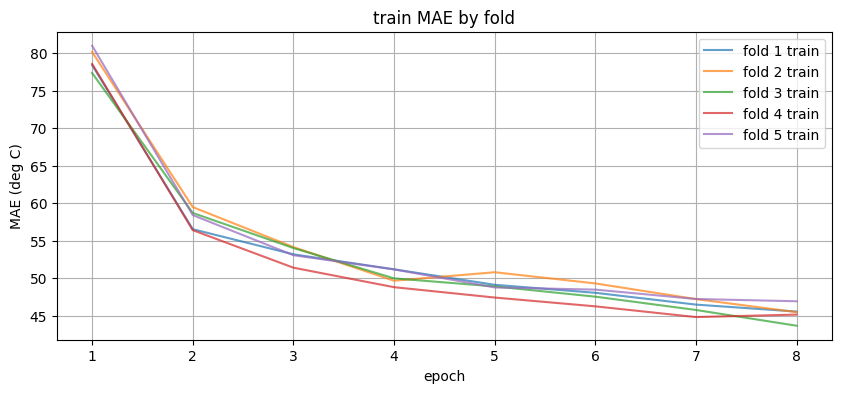

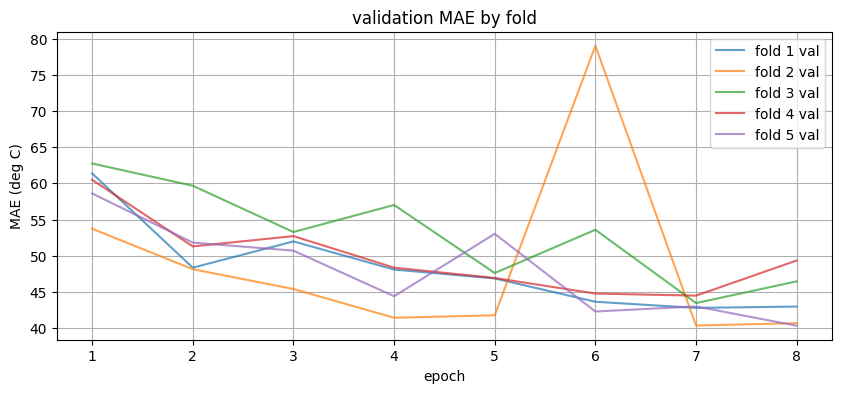

In [30]:
# pip installs (only need once per runtime)
# !pip install rdkit-pypi joblib scikit-learn tqdm --quiet

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from rdkit import Chem
from rdkit.Chem import AllChem
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# config
TARGET_COL = "Tm"
SMILES_COL = "SMILES"
GRID_SIZE = 32
ENCODING_MODE = "per_element"   # "grouped" or "per_element"
BATCH_SIZE = 8
EPOCHS = 8
N_SPLITS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# set random seeds for a bit more reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# get unique atomic numbers across train and test
def get_unique_atomic_numbers(df, smiles_col):
    nums = set()
    for s in df[smiles_col]:
        mol = Chem.MolFromSmiles(s)
        if mol is None:
            continue
        mol = Chem.AddHs(mol)
        for atom in mol.GetAtoms():
            nums.add(atom.GetAtomicNum())
    return sorted(nums)

combined_df = pd.concat([train_df[[SMILES_COL]], test_df[[SMILES_COL]]], ignore_index=True)
unique_Z = get_unique_atomic_numbers(combined_df, SMILES_COL)
print("unique atomic numbers:", unique_Z)

# build atom->channel map, either grouped or per_element
def build_atom_map(unique_Z, mode="grouped"):
    if mode == "per_element":
        atom_map = {z: i for i, z in enumerate(unique_Z)}
        n_channels = len(atom_map)
        return atom_map, n_channels

    # grouped mode: map chemically similar elements to same channel
    atom_map = {}
    ch = 0

    def assign(z_list):
        nonlocal ch
        present = [z for z in z_list if z in unique_Z]
        if present:
            for z in present:
                atom_map[z] = ch
            ch += 1

    # basic groups; tweak if needed
    assign([6])                # C
    assign([8])                # O
    assign([7])                # N
    assign([1])                # H
    assign([9])                # F
    assign([17, 35, 53])       # Cl, Br, I
    assign([16, 15])           # S, P
    assign([14])               # Si

    # any remaining elements go into one extra "other" channel
    remaining = [z for z in unique_Z if z not in atom_map]
    if remaining:
        for z in remaining:
            atom_map[z] = ch
        ch += 1

    return atom_map, ch

ATOM_MAP, VOXEL_CHANNELS = build_atom_map(unique_Z, mode=ENCODING_MODE)
print("encoding mode:", ENCODING_MODE)
print("VOXEL_CHANNELS:", VOXEL_CHANNELS)
print("ATOM_MAP:", ATOM_MAP)

# generate 3D conformers with RDKit
def make_3d_conformer(smiles, random_seed=42):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    mol = Chem.AddHs(mol)
    try:
        params = AllChem.ETKDGv3()
        params.randomSeed = random_seed
        AllChem.EmbedMolecule(mol, params)
        AllChem.MMFFOptimizeMolecule(mol)
        return mol
    except Exception:
        return None

print("generating 3D conformers for train...")
train_df["mol3D"] = Parallel(n_jobs=-1)(
    delayed(make_3d_conformer)(s) for s in tqdm(train_df[SMILES_COL])
)

print("generating 3D conformers for test...")
test_df["mol3D"] = Parallel(n_jobs=-1)(
    delayed(make_3d_conformer)(s) for s in tqdm(test_df[SMILES_COL])
)

print("train mol3D success rate:", train_df["mol3D"].notna().mean())
print("test mol3D success rate:", test_df["mol3D"].notna().mean())

# convert RDKit mol to voxel grid
def mol_to_voxel(mol, atom_map, num_channels, grid_size=GRID_SIZE):
    if mol is None:
        return None

    conf = mol.GetConformer()
    n_atoms = mol.GetNumAtoms()
    coords = np.array(
        [conf.GetAtomPosition(i) for i in range(n_atoms)],
        dtype=np.float32
    )

    # center coordinates
    coords = coords - coords.mean(axis=0)
    max_range = np.abs(coords).max()
    if max_range < 1e-6:
        return None
    coords = coords / (max_range + 1e-6)

    # map from [-1,1] -> [0, grid_size)
    coords = (coords + 1.0) * (grid_size / 2.0)
    coords = coords.astype(int)

    vox = np.zeros((num_channels, grid_size, grid_size, grid_size), dtype=np.float32)

    for i, atom in enumerate(mol.GetAtoms()):
        x, y, z = coords[i]
        if 0 <= x < grid_size and 0 <= y < grid_size and 0 <= z < grid_size:
            znum = atom.GetAtomicNum()
            ch = atom_map.get(znum, None)
            if ch is not None:
                vox[ch, x, y, z] = 1.0

    return vox

print("voxelizing train...")
train_df["vox"] = Parallel(n_jobs=-1)(
    delayed(mol_to_voxel)(mol, ATOM_MAP, VOXEL_CHANNELS)
    for mol in tqdm(train_df["mol3D"])
)

print("voxelizing test...")
test_df["vox"] = Parallel(n_jobs=-1)(
    delayed(mol_to_voxel)(mol, ATOM_MAP, VOXEL_CHANNELS)
    for mol in tqdm(test_df["mol3D"])
)

# drop any rows where voxelization failed
train_df = train_df[train_df["vox"].notna()].reset_index(drop=True)
test_df = test_df[test_df["vox"].notna()].reset_index(drop=True)
print("train size after voxel filter:", len(train_df))
print("test size after voxel filter:", len(test_df))

# compute target normalization stats from full train
y_mean = train_df[TARGET_COL].mean()
y_std = train_df[TARGET_COL].std()
print("Tm mean:", y_mean, "std:", y_std)

# dataset class
class VoxelDataset(Dataset):
    def __init__(self, df, target_col=None):
        self.X = np.stack(df["vox"].values).astype(np.float32)
        self.has_target = target_col is not None
        if self.has_target:
            y = df[target_col].values.astype(np.float32)
            self.y = ((y - y_mean) / y_std).astype(np.float32)
        else:
            self.y = None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.has_target:
            y = torch.tensor(self.y[idx], dtype=torch.float32)
            return x, y
        return x

# 3D CNN model
class Mol3DCNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_channels, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),   # 32 -> 16

            nn.Conv3d(32, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),   # 16 -> 8

            nn.Conv3d(64, 128, 3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d(2),   # 8 -> 4

            nn.Flatten(),
            nn.Linear(128 * 4 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x)

# metric helper: convert back to degrees C
def evaluate_batch(preds, y):
    preds_un = preds * y_std + y_mean
    y_un = y * y_std + y_mean
    mse = torch.mean((preds_un - y_un) ** 2).item()
    mae = torch.mean(torch.abs(preds_un - y_un)).item()
    return mse, mae

# run one epoch (train or val)
def run_epoch(loader, model, optimizer=None):
    train_mode = optimizer is not None
    if train_mode:
        model.train()
    else:
        model.eval()

    total_mse = 0.0
    total_mae = 0.0
    n_samples = 0

    for batch in loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        if train_mode:
            optimizer.zero_grad()

        preds = model(x).squeeze(-1)
        loss = nn.MSELoss()(preds, y)

        if train_mode:
            loss.backward()
            optimizer.step()

        mse, mae = evaluate_batch(preds, y)
        bs = x.size(0)
        total_mse += mse * bs
        total_mae += mae * bs
        n_samples += bs

    return total_mse / n_samples, total_mae / n_samples

# build test loader once
test_dataset = VoxelDataset(test_df, target_col=None)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# k-fold cross validation
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(train_df), dtype=np.float32)
test_preds = np.zeros(len(test_df), dtype=np.float32)

# store MAE history for plotting
fold_train_mae_history = []
fold_val_mae_history = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f"\nfold {fold+1}/{N_SPLITS}")

    trn_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_df = train_df.iloc[val_idx].reset_index(drop=True)

    train_loader = DataLoader(
        VoxelDataset(trn_df, TARGET_COL),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    val_loader = DataLoader(
        VoxelDataset(val_df, TARGET_COL),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    model = Mol3DCNN(in_channels=VOXEL_CHANNELS).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=2
    )

    best_val_mae = float("inf")
    best_path = f"best_fold_{fold}.pt"

    train_mae_list = []
    val_mae_list = []

    for epoch in range(1, EPOCHS + 1):
        train_mse, train_mae = run_epoch(train_loader, model, optimizer)
        val_mse, val_mae = run_epoch(val_loader, model, optimizer=None)

        scheduler.step(val_mse)

        train_mae_list.append(train_mae)
        val_mae_list.append(val_mae)

        print(
            f"epoch {epoch:02d} | "
            f"train MAE: {train_mae:.2f} | "
            f"val MAE: {val_mae:.2f}"
        )

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            torch.save(model.state_dict(), best_path)

    fold_train_mae_history.append(train_mae_list)
    fold_val_mae_history.append(val_mae_list)

    # load best weights for this fold
    model.load_state_dict(torch.load(best_path, map_location=device))
    model.eval()

    # out-of-fold predictions for this fold's val set
    val_preds = []
    with torch.no_grad():
        for x, y in DataLoader(
            VoxelDataset(val_df, TARGET_COL),
            batch_size=BATCH_SIZE,
            shuffle=False
        ):
            x = x.to(device)
            preds = model(x).squeeze(-1)
            preds_un = preds * y_std + y_mean
            val_preds.append(preds_un.cpu().numpy())
    val_preds = np.concatenate(val_preds)
    oof_preds[val_idx] = val_preds

    # accumulate test predictions for ensemble
    fold_test_preds = []
    with torch.no_grad():
        for x in test_loader:
            x = x.to(device)
            preds = model(x).squeeze(-1)
            preds_un = preds * y_std + y_mean
            fold_test_preds.append(preds_un.cpu().numpy())
    fold_test_preds = np.concatenate(fold_test_preds)
    test_preds += fold_test_preds / N_SPLITS

# overall out-of-fold MAE
oof_mae = mean_absolute_error(train_df[TARGET_COL].values, oof_preds)
print("\noof MAE:", round(oof_mae, 3), "deg C")

# plot MAE curves for each fold
epochs_range = np.arange(1, EPOCHS + 1)

plt.figure(figsize=(10, 4))
for f in range(N_SPLITS):
    plt.plot(epochs_range, fold_train_mae_history[f], alpha=0.7, label=f"fold {f+1} train")
plt.xlabel("epoch")
plt.ylabel("MAE (deg C)")
plt.title("train MAE by fold")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
for f in range(N_SPLITS):
    plt.plot(epochs_range, fold_val_mae_history[f], alpha=0.7, label=f"fold {f+1} val")
plt.xlabel("epoch")
plt.ylabel("MAE (deg C)")
plt.title("validation MAE by fold")
plt.legend()
plt.grid(True)
plt.show()

# test_preds now holds ensemble predictions for test_df["Tm"] (in deg C units)
# example of building a submission dataframe if you have an Id column:
# submission = pd.DataFrame({"Id": test_df["Id"], "Tm": test_preds})
# submission.to_csv("submission.csv", index=False)

### 3D CNN with random rotations of compound orientation and 5-fold CV

device: cuda
unique atomic numbers: [1, 6, 7, 8, 9, 14, 15, 16, 17, 35, 53]
encoding mode: per_element
VOXEL_CHANNELS: 11
ATOM_MAP: {1: 0, 6: 1, 7: 2, 8: 3, 9: 4, 14: 5, 15: 6, 16: 7, 17: 8, 35: 9, 53: 10}
generating 3D conformers for train...


100%|██████████| 2659/2659 [00:06<00:00, 402.42it/s]


generating 3D conformers for test...


100%|██████████| 666/666 [00:01<00:00, 574.62it/s]


train mol3D success rate: 1.0
test mol3D success rate: 1.0
voxelizing train...


100%|██████████| 2659/2659 [00:07<00:00, 347.17it/s]


voxelizing test...


100%|██████████| 666/666 [00:01<00:00, 404.86it/s]


train size: 2659 test size: 666
Tm mean: 278.0095374200827 std: 84.30936235458189

fold 1/5
epoch 01 | train MAE: 75.23 | val MAE: 59.81
epoch 02 | train MAE: 58.41 | val MAE: 49.89
epoch 03 | train MAE: 53.99 | val MAE: 49.62
epoch 04 | train MAE: 50.90 | val MAE: 43.74
epoch 05 | train MAE: 49.97 | val MAE: 49.24
epoch 06 | train MAE: 50.14 | val MAE: 49.30
epoch 07 | train MAE: 48.89 | val MAE: 44.27
epoch 08 | train MAE: 48.95 | val MAE: 47.74

fold 2/5
epoch 01 | train MAE: 77.31 | val MAE: 56.22
epoch 02 | train MAE: 59.87 | val MAE: 47.19
epoch 03 | train MAE: 52.78 | val MAE: 41.75
epoch 04 | train MAE: 50.50 | val MAE: 41.99
epoch 05 | train MAE: 51.84 | val MAE: 43.04
epoch 06 | train MAE: 50.49 | val MAE: 48.49
epoch 07 | train MAE: 47.35 | val MAE: 40.80
epoch 08 | train MAE: 47.23 | val MAE: 41.84

fold 3/5
epoch 01 | train MAE: 79.43 | val MAE: 66.60
epoch 02 | train MAE: 60.66 | val MAE: 60.91
epoch 03 | train MAE: 55.28 | val MAE: 56.86
epoch 04 | train MAE: 51.55 | val

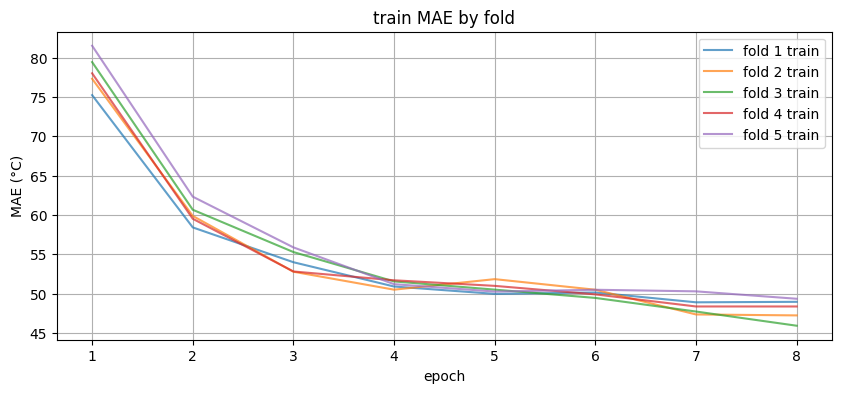

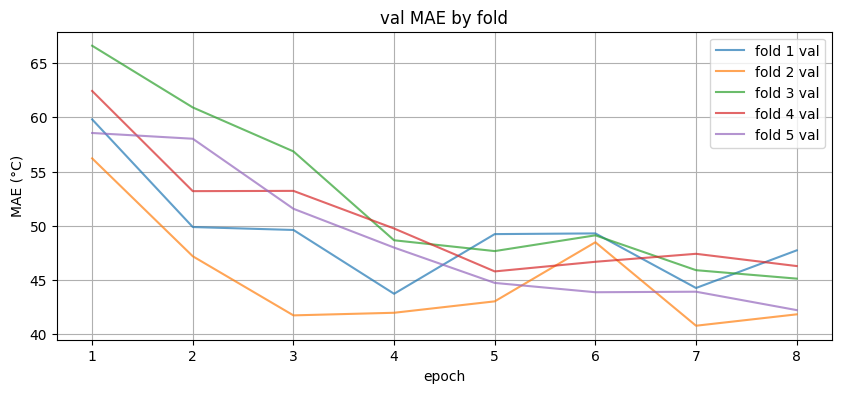

In [31]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from rdkit import Chem
from rdkit.Chem import AllChem
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# config
TARGET_COL = "Tm"
SMILES_COL = "SMILES"
GRID_SIZE = 32
ENCODING_MODE = "per_element"   # "grouped" or "per_element"
BATCH_SIZE = 8
EPOCHS = 8
N_SPLITS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# get unique atomic numbers across train and test
def get_unique_atomic_numbers(df, smiles_col):
    nums = set()
    for s in df[smiles_col]:
        mol = Chem.MolFromSmiles(s)
        if mol is None:
            continue
        mol = Chem.AddHs(mol)
        for atom in mol.GetAtoms():
            nums.add(atom.GetAtomicNum())
    return sorted(nums)

combined_df = pd.concat([train_df[[SMILES_COL]], test_df[[SMILES_COL]]], ignore_index=True)
unique_Z = get_unique_atomic_numbers(combined_df, SMILES_COL)
print("unique atomic numbers:", unique_Z)

# build atom->channel map
def build_atom_map(unique_Z, mode="grouped"):
    if mode == "per_element":
        atom_map = {z: i for i, z in enumerate(unique_Z)}
        return atom_map, len(unique_Z)

    atom_map = {}
    ch = 0

    def assign(z_list):
        nonlocal ch
        present = [z for z in z_list if z in unique_Z]
        if present:
            for z in present:
                atom_map[z] = ch
            ch += 1

    assign([6])
    assign([8])
    assign([7])
    assign([1])
    assign([9])
    assign([17, 35, 53])
    assign([16, 15])
    assign([14])

    rem = [z for z in unique_Z if z not in atom_map]
    if rem:
        for z in rem:
            atom_map[z] = ch
        ch += 1

    return atom_map, ch

ATOM_MAP, VOXEL_CHANNELS = build_atom_map(unique_Z, mode=ENCODING_MODE)
print("encoding mode:", ENCODING_MODE)
print("VOXEL_CHANNELS:", VOXEL_CHANNELS)
print("ATOM_MAP:", ATOM_MAP)

# generate 3D conformers
def make_3d_conformer(smiles, random_seed=42):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    mol = Chem.AddHs(mol)
    try:
        params = AllChem.ETKDGv3()
        params.randomSeed = random_seed
        AllChem.EmbedMolecule(mol, params)
        AllChem.MMFFOptimizeMolecule(mol)
        return mol
    except Exception:
        return None

print("generating 3D conformers for train...")
train_df["mol3D"] = Parallel(n_jobs=-1)(
    delayed(make_3d_conformer)(s) for s in tqdm(train_df[SMILES_COL])
)

print("generating 3D conformers for test...")
test_df["mol3D"] = Parallel(n_jobs=-1)(
    delayed(make_3d_conformer)(s) for s in tqdm(test_df[SMILES_COL])
)

print("train mol3D success rate:", train_df["mol3D"].notna().mean())
print("test mol3D success rate:", test_df["mol3D"].notna().mean())

# voxelization
def mol_to_voxel(mol, atom_map, num_channels, grid_size=GRID_SIZE):
    if mol is None:
        return None

    conf = mol.GetConformer()
    coords = np.array([conf.GetAtomPosition(i) for i in range(mol.GetNumAtoms())], dtype=np.float32)
    coords = coords - coords.mean(axis=0)
    max_range = np.abs(coords).max()
    if max_range < 1e-6:
        return None
    coords = coords / (max_range + 1e-6)
    coords = (coords + 1.0) * (grid_size / 2.0)
    coords = coords.astype(int)

    vox = np.zeros((num_channels, grid_size, grid_size, grid_size), dtype=np.float32)
    for i, atom in enumerate(mol.GetAtoms()):
        x,y,z = coords[i]
        if 0<=x<grid_size and 0<=y<grid_size and 0<=z<grid_size:
            ch = atom_map.get(atom.GetAtomicNum(), None)
            if ch is not None:
                vox[ch, x, y, z] = 1.0
    return vox

print("voxelizing train...")
train_df["vox"] = Parallel(n_jobs=-1)(
    delayed(mol_to_voxel)(mol, ATOM_MAP, VOXEL_CHANNELS)
    for mol in tqdm(train_df["mol3D"])
)

print("voxelizing test...")
test_df["vox"] = Parallel(n_jobs=-1)(
    delayed(mol_to_voxel)(mol, ATOM_MAP, VOXEL_CHANNELS)
    for mol in tqdm(test_df["mol3D"])
)

# filter out failed voxels
train_df = train_df[train_df["vox"].notna()].reset_index(drop=True)
test_df = test_df[test_df["vox"].notna()].reset_index(drop=True)
print("train size:", len(train_df), "test size:", len(test_df))

# normalize target
y_mean = train_df[TARGET_COL].mean()
y_std  = train_df[TARGET_COL].std()
print("Tm mean:", y_mean, "std:", y_std)

# rotation augmentation
def random_rotate(vox):
    kx = random.randint(0,3)
    ky = random.randint(0,3)
    kz = random.randint(0,3)
    vox = torch.rot90(vox, k=kx, dims=[1,2])
    vox = torch.rot90(vox, k=ky, dims=[1,3])
    vox = torch.rot90(vox, k=kz, dims=[2,3])
    return vox

# dataset
class VoxelDataset(Dataset):
    def __init__(self, df, target_col=None, augment=False):
        self.X = np.stack(df["vox"].values).astype(np.float32)
        self.has_target = target_col is not None
        self.augment = augment
        if self.has_target:
            y = df[target_col].values.astype(np.float32)
            self.y = ((y - y_mean) / y_std).astype(np.float32)

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.augment:
            x = random_rotate(x)
        if self.has_target:
            y = torch.tensor(self.y[idx], dtype=torch.float32)
            return x, y
        return x

# model
class Mol3DCNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_channels, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(32, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(64, 128, 3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Flatten(),
            nn.Linear(128*4*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )
    def forward(self, x): return self.net(x)

# metrics back to °C
def evaluate_batch(preds, y):
    preds_un = preds * y_std + y_mean
    y_un = y * y_std + y_mean
    mse = torch.mean((preds_un - y_un)**2).item()
    mae = torch.mean(torch.abs(preds_un - y_un)).item()
    return mse, mae

# one epoch
def run_epoch(loader, model, optimizer=None):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()
    total_mse = 0.0
    total_mae = 0.0
    count = 0
    for batch in loader:
        x,y = batch
        x = x.to(device)
        y = y.to(device)
        if train_mode:
            optimizer.zero_grad()
        preds = model(x).squeeze(-1)
        loss = nn.MSELoss()(preds, y)
        if train_mode:
            loss.backward()
            optimizer.step()
        mse, mae = evaluate_batch(preds, y)
        bs = x.size(0)
        total_mse += mse*bs
        total_mae += mae*bs
        count += bs
    return total_mse/count, total_mae/count

# test loader (no augmentation)
test_dataset = VoxelDataset(test_df, target_col=None, augment=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# k-fold
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
oof_preds = np.zeros(len(train_df), dtype=np.float32)
test_preds = np.zeros(len(test_df), dtype=np.float32)
fold_train_mae = []
fold_val_mae = []

for fold,(tr_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f"\nfold {fold+1}/{N_SPLITS}")

    trn_df = train_df.iloc[tr_idx].reset_index(drop=True)
    val_df = train_df.iloc[val_idx].reset_index(drop=True)

    train_loader = DataLoader(
        VoxelDataset(trn_df, TARGET_COL, augment=True),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    val_loader = DataLoader(
        VoxelDataset(val_df, TARGET_COL, augment=False),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    model = Mol3DCNN(in_channels=VOXEL_CHANNELS).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=2
    )

    best_mae = float("inf")
    path = f"best_fold_{fold}.pt"

    tr_mae_hist, va_mae_hist = [], []

    for epoch in range(1, EPOCHS+1):
        tr_mse, tr_mae = run_epoch(train_loader, model, optimizer)
        va_mse, va_mae = run_epoch(val_loader, model)
        scheduler.step(va_mse)

        tr_mae_hist.append(tr_mae)
        va_mae_hist.append(va_mae)

        print(f"epoch {epoch:02d} | train MAE: {tr_mae:.2f} | val MAE: {va_mae:.2f}")

        if va_mae < best_mae:
            best_mae = va_mae
            torch.save(model.state_dict(), path)

    fold_train_mae.append(tr_mae_hist)
    fold_val_mae.append(va_mae_hist)

    # reload best
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

    # OOF preds
    preds_val=[]
    with torch.no_grad():
        for x,y in DataLoader(VoxelDataset(val_df, TARGET_COL, augment=False),
                              batch_size=BATCH_SIZE, shuffle=False):
            x = x.to(device)
            preds = model(x).squeeze(-1)
            preds_un = preds*y_std + y_mean
            preds_val.append(preds_un.cpu().numpy())
    preds_val = np.concatenate(preds_val)
    oof_preds[val_idx] = preds_val

    # test preds
    fold_test=[]
    with torch.no_grad():
        for x in test_loader:
            x = x.to(device)
            preds = model(x).squeeze(-1)
            preds_un = preds*y_std + y_mean
            fold_test.append(preds_un.cpu().numpy())
    test_preds += np.concatenate(fold_test)/N_SPLITS

# overall oof performance
oof_mae = mean_absolute_error(train_df[TARGET_COL].values, oof_preds)
print("\noof MAE:", round(oof_mae,3), "deg C")

# plot mae curves
epochs_range = np.arange(1,EPOCHS+1)
plt.figure(figsize=(10,4))
for f in range(N_SPLITS):
    plt.plot(epochs_range, fold_train_mae[f], alpha=0.7, label=f"fold {f+1} train")
plt.xlabel("epoch")
plt.ylabel("MAE (°C)")
plt.title("train MAE by fold")
plt.legend(), plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
for f in range(N_SPLITS):
    plt.plot(epochs_range, fold_val_mae[f], alpha=0.7, label=f"fold {f+1} val")
plt.xlabel("epoch")
plt.ylabel("MAE (°C)")
plt.title("val MAE by fold")
plt.legend(), plt.grid(True)
plt.show()

## 3D CNN With 5-fold cross validation and rotations and Multi-Conformers

device: cuda
unique atomic numbers: [1, 6, 7, 8, 9, 14, 15, 16, 17, 35, 53]
encoding mode: per_element
VOXEL_CHANNELS: 11
ATOM_MAP: {1: 0, 6: 1, 7: 2, 8: 3, 9: 4, 14: 5, 15: 6, 16: 7, 17: 8, 35: 9, 53: 10}
generating 3D conformers for train...


100%|██████████| 2659/2659 [00:32<00:00, 81.25it/s]


generating 3D conformers for test...


100%|██████████| 666/666 [00:07<00:00, 93.53it/s]


train molecules with >=1 conformer: 1.0
test molecules with >=1 conformer: 1.0
voxelizing train (multi-conformer)...


100%|██████████| 2659/2659 [00:41<00:00, 63.68it/s]


voxelizing test (multi-conformer)...


100%|██████████| 666/666 [00:09<00:00, 67.14it/s]


train size after voxel filter: 2659
test size after voxel filter: 666
Tm mean: 278.0095374200827 std: 84.30936235458189

fold 1/5
epoch 01 | train MAE: 77.10 | val MAE: 62.15
epoch 02 | train MAE: 56.74 | val MAE: 47.96
epoch 03 | train MAE: 53.80 | val MAE: 49.52
epoch 04 | train MAE: 51.48 | val MAE: 44.49
epoch 05 | train MAE: 49.64 | val MAE: 47.88
epoch 06 | train MAE: 49.25 | val MAE: 44.62
epoch 07 | train MAE: 48.79 | val MAE: 47.41
epoch 08 | train MAE: 48.27 | val MAE: 41.72

fold 2/5
epoch 01 | train MAE: 81.45 | val MAE: 57.65
epoch 02 | train MAE: 60.60 | val MAE: 47.76
epoch 03 | train MAE: 54.68 | val MAE: 47.42
epoch 04 | train MAE: 52.86 | val MAE: 46.81
epoch 05 | train MAE: 52.22 | val MAE: 45.77
epoch 06 | train MAE: 51.46 | val MAE: 41.46
epoch 07 | train MAE: 49.61 | val MAE: 45.47
epoch 08 | train MAE: 48.37 | val MAE: 49.77

fold 3/5
epoch 01 | train MAE: 78.14 | val MAE: 64.37
epoch 02 | train MAE: 54.40 | val MAE: 50.43
epoch 03 | train MAE: 50.68 | val MAE: 6

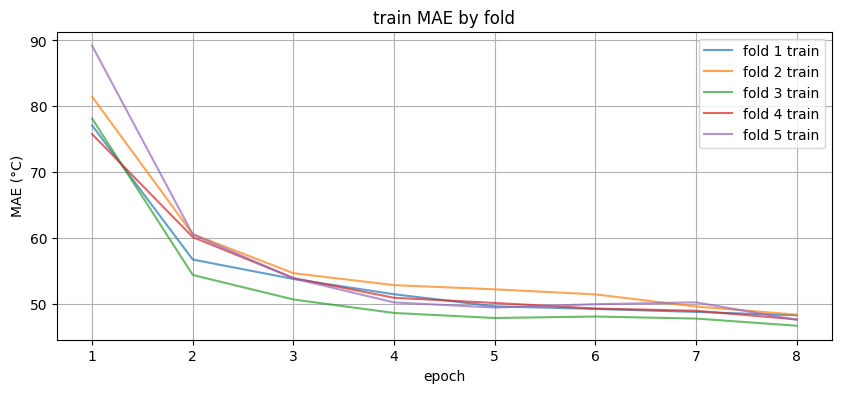

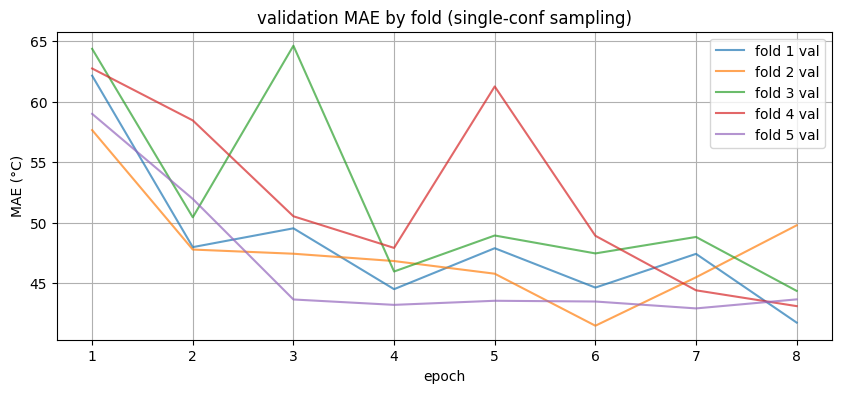

In [33]:
# basic installs (once per runtime)
# !pip install rdkit-pypi joblib scikit-learn tqdm --quiet

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from rdkit import Chem
from rdkit.Chem import AllChem
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# config
TARGET_COL = "Tm"
SMILES_COL = "SMILES"
GRID_SIZE = 32
ENCODING_MODE = "per_element"   # "grouped" or "per_element"
N_CONFORMERS = 5
BATCH_SIZE = 8
EPOCHS = 8
N_SPLITS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# get unique atomic numbers
def get_unique_atomic_numbers(df, smiles_col):
    nums = set()
    for s in df[smiles_col]:
        mol = Chem.MolFromSmiles(s)
        if mol is None:
            continue
        mol = Chem.AddHs(mol)
        for atom in mol.GetAtoms():
            nums.add(atom.GetAtomicNum())
    return sorted(nums)

combined_df = pd.concat(
    [train_df[[SMILES_COL]], test_df[[SMILES_COL]]],
    ignore_index=True
)
unique_Z = get_unique_atomic_numbers(combined_df, SMILES_COL)
print("unique atomic numbers:", unique_Z)

# atom -> channel mapping
def build_atom_map(unique_Z, mode="grouped"):
    if mode == "per_element":
        atom_map = {z: i for i, z in enumerate(unique_Z)}
        return atom_map, len(unique_Z)

    atom_map = {}
    ch = 0

    def assign(z_list):
        nonlocal ch
        present = [z for z in z_list if z in unique_Z]
        if present:
            for z in present:
                atom_map[z] = ch
            ch += 1

    assign([6])                 # C
    assign([8])                 # O
    assign([7])                 # N
    assign([1])                 # H
    assign([9])                 # F
    assign([17, 35, 53])        # Cl, Br, I
    assign([16, 15])            # S, P
    assign([14])                # Si

    remaining = [z for z in unique_Z if z not in atom_map]
    if remaining:
        for z in remaining:
            atom_map[z] = ch
        ch += 1

    return atom_map, ch

ATOM_MAP, VOXEL_CHANNELS = build_atom_map(unique_Z, mode=ENCODING_MODE)
print("encoding mode:", ENCODING_MODE)
print("VOXEL_CHANNELS:", VOXEL_CHANNELS)
print("ATOM_MAP:", ATOM_MAP)

# generate multiple 3D conformers per molecule
def make_3d_conformers(smiles, n_conf=5, random_seed=42):
    mol0 = Chem.MolFromSmiles(smiles)
    if mol0 is None:
        return []
    mol0 = Chem.AddHs(mol0)
    mol_list = []
    for i in range(n_conf):
        mol = Chem.Mol(mol0)
        try:
            params = AllChem.ETKDGv3()
            params.randomSeed = random_seed + i
            AllChem.EmbedMolecule(mol, params)
            AllChem.MMFFOptimizeMolecule(mol)
            mol_list.append(mol)
        except Exception:
            continue
    return mol_list

print("generating 3D conformers for train...")
train_df["mol3D_list"] = Parallel(n_jobs=-1)(
    delayed(make_3d_conformers)(s, n_conf=N_CONFORMERS)
    for s in tqdm(train_df[SMILES_COL])
)

print("generating 3D conformers for test...")
test_df["mol3D_list"] = Parallel(n_jobs=-1)(
    delayed(make_3d_conformers)(s, n_conf=N_CONFORMERS)
    for s in tqdm(test_df[SMILES_COL])
)

print("train molecules with >=1 conformer:", (train_df["mol3D_list"].apply(len) > 0).mean())
print("test molecules with >=1 conformer:", (test_df["mol3D_list"].apply(len) > 0).mean())

# single-mol voxelizer (one conformer)
def mol_to_voxel(mol, atom_map, num_channels, grid_size=GRID_SIZE):
    if mol is None:
        return None
    conf = mol.GetConformer()
    coords = np.array(
        [conf.GetAtomPosition(i) for i in range(mol.GetNumAtoms())],
        dtype=np.float32
    )
    coords = coords - coords.mean(axis=0)
    max_range = np.abs(coords).max()
    if max_range < 1e-6:
        return None
    coords = coords / (max_range + 1e-6)
    coords = (coords + 1.0) * (grid_size / 2.0)
    coords = coords.astype(int)

    vox = np.zeros((num_channels, grid_size, grid_size, grid_size), dtype=np.float32)
    for i, atom in enumerate(mol.GetAtoms()):
        x, y, z = coords[i]
        if 0 <= x < grid_size and 0 <= y < grid_size and 0 <= z < grid_size:
            znum = atom.GetAtomicNum()
            ch = atom_map.get(znum, None)
            if ch is not None:
                vox[ch, x, y, z] = 1.0
    return vox

# list-of-mols -> list-of-voxels
def mols_to_vox_list(mol_list, atom_map, num_channels, grid_size=GRID_SIZE):
    vox_list = []
    for mol in mol_list:
        v = mol_to_voxel(mol, atom_map, num_channels, grid_size)
        if v is not None:
            vox_list.append(v)
    if len(vox_list) == 0:
        return None
    return vox_list

print("voxelizing train (multi-conformer)...")
train_df["vox_list"] = Parallel(n_jobs=-1)(
    delayed(mols_to_vox_list)(mols, ATOM_MAP, VOXEL_CHANNELS)
    for mols in tqdm(train_df["mol3D_list"])
)

print("voxelizing test (multi-conformer)...")
test_df["vox_list"] = Parallel(n_jobs=-1)(
    delayed(mols_to_vox_list)(mols, ATOM_MAP, VOXEL_CHANNELS)
    for mols in tqdm(test_df["mol3D_list"])
)

# drop molecules where all conformers failed
train_df = train_df[train_df["vox_list"].notna()].reset_index(drop=True)
test_df = test_df[test_df["vox_list"].notna()].reset_index(drop=True)
print("train size after voxel filter:", len(train_df))
print("test size after voxel filter:", len(test_df))

# target normalization
y_mean = train_df[TARGET_COL].mean()
y_std = train_df[TARGET_COL].std()
print("Tm mean:", y_mean, "std:", y_std)

# rotation augmentation
def random_rotate(vox):
    # vox has shape (C, X, Y, Z)
    kx = random.randint(0, 3)
    ky = random.randint(0, 3)
    kz = random.randint(0, 3)
    vox = torch.rot90(vox, k=kx, dims=[1, 2])
    vox = torch.rot90(vox, k=ky, dims=[1, 3])
    vox = torch.rot90(vox, k=kz, dims=[2, 3])
    return vox

# dataset that samples a random conformer each time
class VoxelDataset(Dataset):
    def __init__(self, df, target_col=None, augment=False):
        self.vox_lists = df["vox_list"].values
        self.has_target = target_col is not None
        self.augment = augment
        if self.has_target:
            y = df[target_col].values.astype(np.float32)
            self.y = ((y - y_mean) / y_std).astype(np.float32)

    def __len__(self):
        return len(self.vox_lists)

    def __getitem__(self, idx):
        vox_list = self.vox_lists[idx]
        # pick a random conformer for this sample
        k = random.randint(0, len(vox_list) - 1)
        x_np = vox_list[k]
        x = torch.tensor(x_np, dtype=torch.float32)
        if self.augment:
            x = random_rotate(x)
        if self.has_target:
            y = torch.tensor(self.y[idx], dtype=torch.float32)
            return x, y
        return x

# model
class Mol3DCNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_channels, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(32, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(64, 128, 3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Flatten(),
            nn.Linear(128 * 4 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x)

# metrics back in °C
def evaluate_batch(preds, y):
    preds_un = preds * y_std + y_mean
    y_un = y * y_std + y_mean
    mse = torch.mean((preds_un - y_un) ** 2).item()
    mae = torch.mean(torch.abs(preds_un - y_un)).item()
    return mse, mae

# one epoch over a loader
def run_epoch(loader, model, optimizer=None):
    train_mode = optimizer is not None
    if train_mode:
        model.train()
    else:
        model.eval()

    total_mse = 0.0
    total_mae = 0.0
    count = 0

    for batch in loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        if train_mode:
            optimizer.zero_grad()

        preds = model(x).squeeze(-1)
        loss = nn.MSELoss()(preds, y)

        if train_mode:
            loss.backward()
            optimizer.step()

        mse, mae = evaluate_batch(preds, y)
        bs = x.size(0)
        total_mse += mse * bs
        total_mae += mae * bs
        count += bs

    return total_mse / count, total_mae / count

# multi-conformer prediction for a whole dataframe
def predict_multi_conformer(df, model):
    model.eval()
    preds_all = []
    with torch.no_grad():
        for vox_list in df["vox_list"]:
            conf_preds = []
            for v in vox_list:
                x = torch.tensor(v, dtype=torch.float32).unsqueeze(0).to(device)
                p_norm = model(x).squeeze(-1).item()
                p = p_norm * y_std + y_mean
                conf_preds.append(p)
            preds_all.append(np.mean(conf_preds))
    return np.array(preds_all, dtype=np.float32)

# test loader (not actually used for multi-conf averaging, but kept for symmetry)
test_dataset = VoxelDataset(test_df, target_col=None, augment=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# k-fold
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
oof_preds = np.zeros(len(train_df), dtype=np.float32)
test_preds = np.zeros(len(test_df), dtype=np.float32)

fold_train_mae = []
fold_val_mae = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f"\nfold {fold+1}/{N_SPLITS}")

    trn_df = train_df.iloc[tr_idx].reset_index(drop=True)
    val_df = train_df.iloc[val_idx].reset_index(drop=True)

    train_loader = DataLoader(
        VoxelDataset(trn_df, TARGET_COL, augment=True),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    val_loader = DataLoader(
        VoxelDataset(val_df, TARGET_COL, augment=False),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    model = Mol3DCNN(in_channels=VOXEL_CHANNELS).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=2
    )

    best_mae = float("inf")
    best_path = f"best_fold_{fold}.pt"

    tr_mae_hist = []
    va_mae_hist = []

    for epoch in range(1, EPOCHS + 1):
        train_mse, train_mae = run_epoch(train_loader, model, optimizer)
        val_mse, val_mae = run_epoch(val_loader, model, optimizer=None)

        scheduler.step(val_mse)

        tr_mae_hist.append(train_mae)
        va_mae_hist.append(val_mae)

        print(
            f"epoch {epoch:02d} | "
            f"train MAE: {train_mae:.2f} | "
            f"val MAE: {val_mae:.2f}"
        )

        if val_mae < best_mae:
            best_mae = val_mae
            torch.save(model.state_dict(), best_path)

    fold_train_mae.append(tr_mae_hist)
    fold_val_mae.append(va_mae_hist)

    # reload best weights
    model.load_state_dict(torch.load(best_path, map_location=device))

    # multi-conformer OOF preds on this fold's val set
    val_preds = predict_multi_conformer(val_df, model)
    oof_preds[val_idx] = val_preds

    # multi-conformer test preds for this fold
    fold_test_preds = predict_multi_conformer(test_df, model)
    test_preds += fold_test_preds / N_SPLITS

# overall OOF MAE
oof_mae = mean_absolute_error(train_df[TARGET_COL].values.astype(np.float32), oof_preds)
print("\noof MAE:", round(oof_mae, 3), "deg C")

# plot MAE curves
epochs_range = np.arange(1, EPOCHS + 1)

plt.figure(figsize=(10, 4))
for f in range(N_SPLITS):
    plt.plot(epochs_range, fold_train_mae[f], alpha=0.7, label=f"fold {f+1} train")
plt.xlabel("epoch")
plt.ylabel("MAE (°C)")
plt.title("train MAE by fold")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
for f in range(N_SPLITS):
    plt.plot(epochs_range, fold_val_mae[f], alpha=0.7, label=f"fold {f+1} val")
plt.xlabel("epoch")
plt.ylabel("MAE (°C)")
plt.title("validation MAE by fold (single-conf sampling)")
plt.legend()
plt.grid(True)
plt.show()

# test_preds now holds ensemble multi-conformer predictions in °C for test_df
# example:
# submission = pd.DataFrame({"Id": test_df["Id"], "Tm": test_preds})
# submission.to_csv("submission.csv", index=False)

In [34]:
train_df.head()


,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424,mol3D,vox,mol3D_list,vox_list
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x78bc7817c6d0>,[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[<rdkit.Chem.rdchem.Mol object at 0x78bc780fe1...,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x78bc78145d50>,[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[<rdkit.Chem.rdchem.Mol object at 0x78bc715134...,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x78bc7810ed40>,[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[<rdkit.Chem.rdchem.Mol object at 0x78bc715118...,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x78bc7810d2b0>,[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[<rdkit.Chem.rdchem.Mol object at 0x78bc71512f...,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x78bc7810ecf0>,[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[<rdkit.Chem.rdchem.Mol object at 0x78bc71510f...,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....


## Simple XGBRegressor Model

In [17]:
import gc
if 'model' in globals():
    del model
gc.collect()

36745

In [26]:
!pip install xgboost --quiet

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

group_cols = [c for c in train_df.columns if c.startswith("Group")]
print("number of group features:", len(group_cols))

X = train_df[group_cols].values.astype(np.float32)
y = train_df["Tm"].values.astype(np.float32)
X_test = test_df[group_cols].values.astype(np.float32)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros(len(train_df), dtype=np.float32)
test_preds = np.zeros(len(test_df), dtype=np.float32)
fold_maes = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nfold {fold+1}/5")

    X_tr, X_val = X[tr_idx], X[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]

    # simplest configuration
    model = xgb.XGBRegressor(
        n_estimators=3000,
        max_depth=5,
        learning_rate=0.1,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        tree_method="hist"
    )

    # TRAIN (no eval_set, no early stopping)
    model.fit(X_tr, y_tr)

    # PREDICT
    val_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, val_pred)
    fold_maes.append(mae)
    print("fold val MAE:", round(mae, 3))

    oof_preds[val_idx] = val_pred
    test_preds += model.predict(X_test) / 5

# Final evaluation
oof_mae = mean_absolute_error(y, oof_preds)
print("\n===========================")
print("mean fold MAE:", round(np.mean(fold_maes), 3))
print("oof MAE:", round(oof_mae, 3), "deg C")
print("===========================")

number of group features: 424

fold 1/5
fold val MAE: 33.572

fold 2/5
fold val MAE: 35.169

fold 3/5
fold val MAE: 33.877

fold 4/5
fold val MAE: 33.742

fold 5/5
fold val MAE: 33.767

mean fold MAE: 34.025
oof MAE: 34.026 deg C


## Submission data

In [10]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "Tm": test_preds  # from the XGBoost run
})
submission.to_csv("submission_xgb_groups.csv", index=False)

## RandomizedSearchCV

In [25]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
import xgboost as xgb
import numpy as np

X = train_df[group_cols].values.astype(np.float32)
y = train_df["Tm"].values.astype(np.float32)

param_dist = {
    "max_depth": [4, 5, 6, 7, 8],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10],
    "n_estimators": [10, 50, 100, 1000, 3000, 5000],
}

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# search = RandomizedSearchCV(
#     model,
#     param_distributions=param_dist,
#     n_iter=20,           # try 20 random combos
#     scoring=mae_scorer,
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

search = GridSearchCV(
    model,
    param_grid=param_dist,
    scoring=mae_scorer,
    cv=2,
    verbose=1,
    n_jobs=-1
)

search.fit(X, y)

print("Best MAE (negative):", search.best_score_)
print("Best parameters:", search.best_params_)

Fitting 2 folds for each of 240 candidates, totalling 480 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-6.52688103e+01 -6.51729851e+01 -6.50549812e+01 -6.31192150e+01
 -5.97730732e+01 -5.73333988e+01 -6.52668381e+01 -6.51631737e+01
 -6.50361862e+01 -6.29537926e+01 -5.93733158e+01 -5.67453976e+01
 -6.52656288e+01 -6.51570740e+01 -6.50229454e+01 -6.28515263e+01
 -5.90212994e+01 -5.61354885e+01 -6.52640686e+01 -6.51493187e+01
 -6.50091553e+01 -6.27311954e+01 -5.86959801e+01 -5.54751720e+01
 -6.52630386e+01 -6.51441498e+01 -6.49969444e+01 -6.26223679e+01
 -5.83962040e+01 -5.50902729e+01 -6.50549126e+01 -6.41578522e+01
 -6.31183834e+01 -5.34718018e+01 -4.82544975e+01 -4.62984009e+01
 -6.50359764e+01 -6.40674858e+01 -6.29526291e+01 -5.22591152e+01
 -4.62744389e+01 -4.43756733e+01 -6.50227623e+01 -6.40165958e+01
 -6.28506603e+01 -5.13397179e+01 -4.49912930e+01 -4.32519455e+01
 -6.50089149e+01 -6.39520435e+01 -6.27295933e+01 -5.04078636e+01
 -4.39043255e+

Best MAE (negative): -36.75310707092285
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}


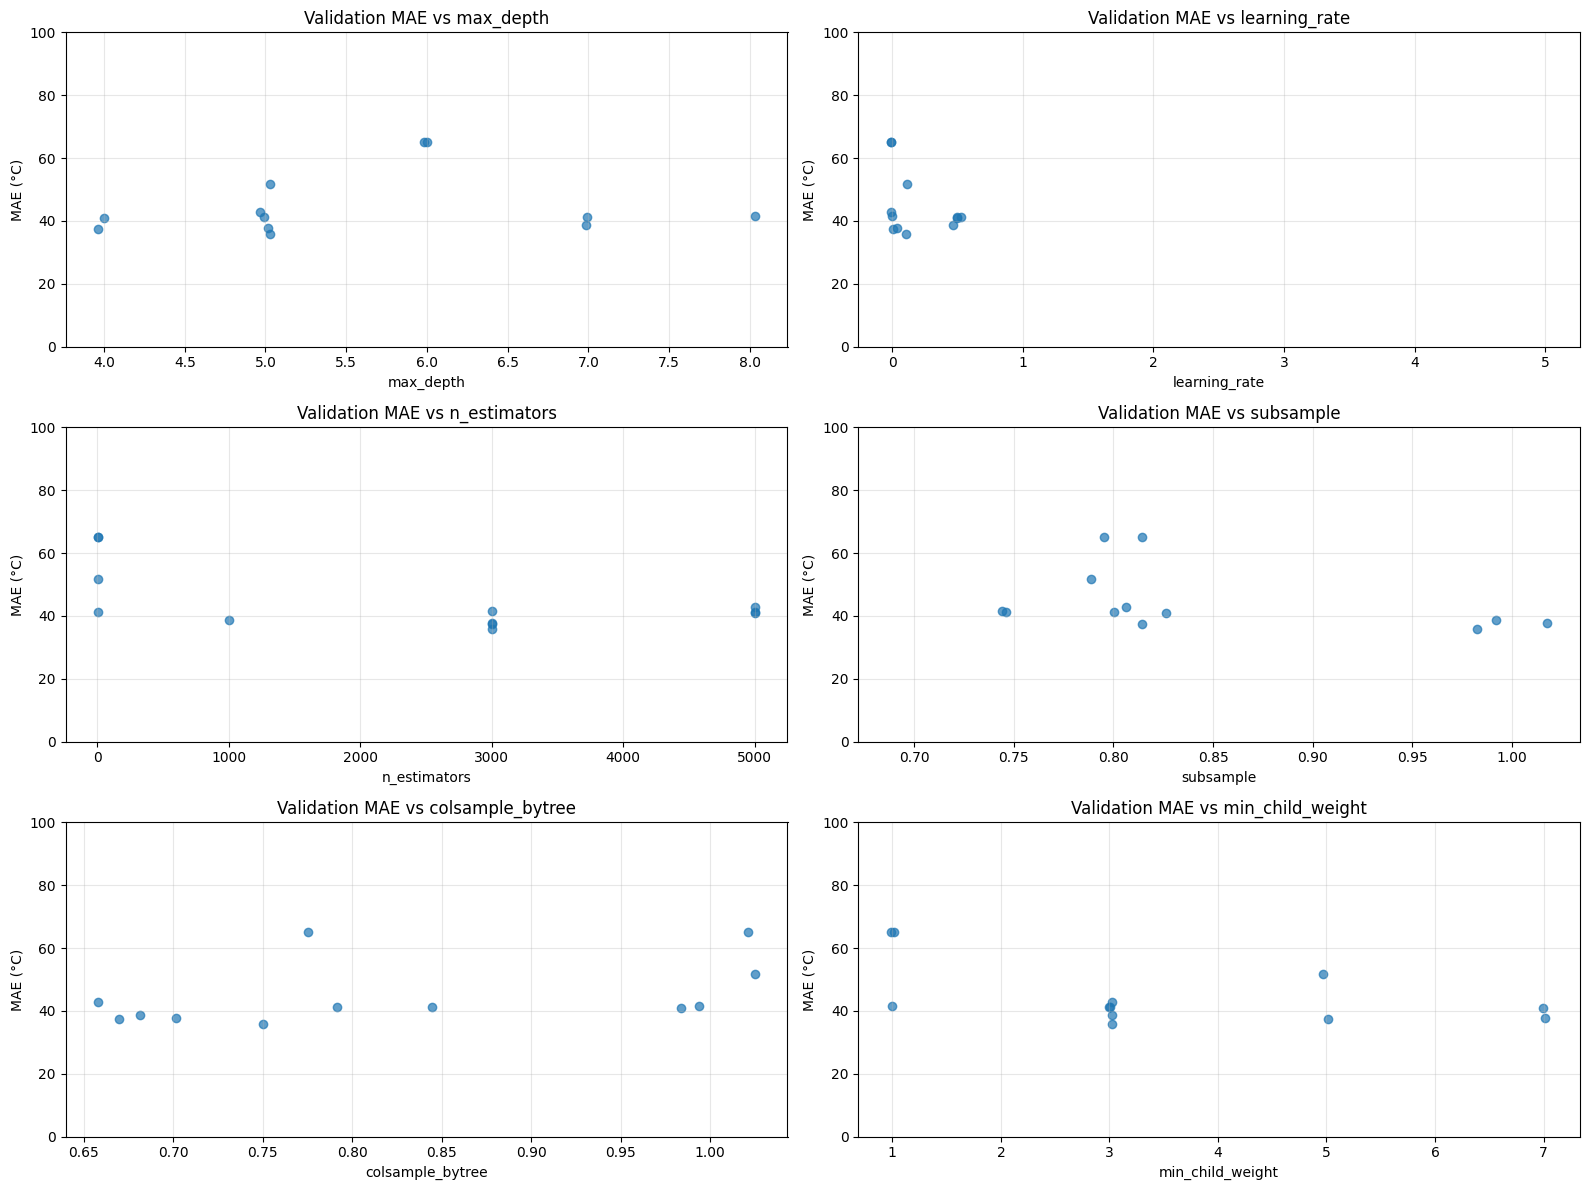

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# convert results to DataFrame
cv_results = pd.DataFrame(search.cv_results_)

# convert negative MAE to positive
cv_results["MAE"] = -cv_results["mean_test_score"]

# parameters to visualize
params_to_plot = list(param_dist.keys())

num_params = len(params_to_plot)
plt.figure(figsize=(16, 4 * ((num_params+1)//2)))

for i, param in enumerate(params_to_plot, 1):
    plt.subplot((num_params+1)//2, 2, i)

    # align scores to param values
    x = cv_results[f"param_{param}"]
    y = cv_results["MAE"]

    # jitter x slightly for readability if categorical
    if len(x.unique()) < 10:
        jitter = np.random.normal(0, 0.02, size=len(x))
        plt.scatter(x + jitter, y, alpha=0.7)
    else:
        plt.scatter(x, y, alpha=0.7)

    # formatting
    plt.title(f"Validation MAE vs {param}")
    plt.xlabel(param)
    plt.ylim(0, 100)
    plt.ylabel("MAE (°C)")
    plt.grid(alpha=0.3)

# overall layout
plt.tight_layout()
plt.show()